Here is the problem we set out to day:
to estimate blood concentrations of estradol at all hours of day,
given a particular dosing regime and blood tests taken at a particular time.
I am honestly surprised noone has done this.
The intersection of trans folk and scientific computing is non-trivial.

To do this we are going to use probabablistic programming.
This is a great usecase for probablistic programming.
We have a ton of domain knowledge, but that domain knowledge has a few (not many) parameters we don't know, and we have only a little data.
Furthermore we would love to get a distribution over possible answers out of the system.


From [this blog post on Sublingual versus Oral Estrogen](http://transascity.org/sublingual-versus-oral-estrogen/) they approximated the estradoil function with a linear to the peak then an expodential decay.

> I plotted points from the sublingual estradiol curve, and came up with an estimate of the estradiol function from 1 hr to 24 hours as being `350.54*(HOURS^-0.907)`. From 0 to 1 hours, I estimated the estradiol level linearly, as `451*HOURS`.


I am today interested in the estradiol function for estradiol gel.
It's the same shape, so a similar strategy should apply.


Järvinen A, Granander M, Nykänen S, Laine T, Geurts P, Viitanen A (November 1997). "Steady-state pharmacokinetics of oestradiol gel in post-menopausal women: effects of application area and washing". Br J Obstet Gynaecol. 104 Suppl 16: 14–8. doi:10.111/j.1471-0528.1997.tb11562.x. PMID 9389778. S2CID 36677042.
give 3 curves for single dose.
Which are also available from Wikimedia Commons. Plots below:
![](https://upload.wikimedia.org/wikipedia/commons/1/19/Estradiol_levels_with_1_mg_per_day_transdermal_estradiol_gel_applied_to_different_amounts_of_area_in_postmenopausal_women.png)
These 3 curve in that study were from different application areas.
For our purposes that doesn't matter.
We instead can characterise them as 3 different realistic curves, which have some differences based on various causes (be they application area, location, physiology etc).
We will then estimate the parameters of those curves.

In [ ]:
repr([30, 39,42,45,37,35,30,27,30,30,29] .- 25) |> x-> replace(x, " "=>"")


In [ ]:
using Pkg: @pkg_str
pkg"activate --temp"
pkg"add Tables@1 Plots@1 Turing@0.21.12 MCMCChains@5.5 LsqFit@0.13.0"

In [ ]:
function single_dose(c_max, halflife, t_max)
    function(t)
        if t < t_max
            c_max/t_max * t
        else
            c_max * 2^(-(t-t_max)/halflife)
        end
    end
end

Let's see how we did.
I am going to plot the data from Järvinen et al against curves using my formula, best fit by my own inspection.
I am downshifting all the data from Järvinen by 25 pg/mL, as that data was from postmenopausal cis women, who produce about 25 pg/mL of estradoil on their own before you take into account HRT.
We only want to model the HRT component.

In [ ]:
using Plots
plot(layout=(1,3))

plot!(
    0:0.1:24, single_dose(132, 3.5, 3),
    label="A200 predicted"; linecolor=:red, subplot=1, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red, subplot=1, yrange=(0,130),
)

plot!(
    single_dose(100, 3.5, 2.5),
    label="A400 predicted", linecolor=:magenta, subplot=2, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [25,35,70,75,55,45,35,32,22,15,4];
    label="A400 actual", markercolor=:magenta, subplot=2, yrange=(0,130),
)

plot!(
    single_dose(20, 3.5, 2.7),
    label="Amax predicted", linecolor=:blue, subplot=3, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [5,14,17,20,12,10,5,2,5,5,4];
    label="Amax actual", markercolor=:blue, subplot=3, yrange=(0,130),
)

By looking at these plots, it seems a pretty decent model.
Of-course with enough degrees of freedom, you can fit an elephant.
However we have 10 points and only 3 degrees of freedom, of which we only varied 2 of them across the 3 datasets.
So it seems like we are good.

It's broadly biologically plausable.
We expect a fast intial absorbsion, that should end at some point in few few hours -- 1-4 is various comments on how long to avoid showering on the packets depending on brand.
Since it is fast and short, it doesn't really matter what we model it with, so linear is fine.
Then we expect a tail off as it is consumed.
It makes sense for the rate of absorbsion to be related to the quanity remaining -- which suggests some expodential.
We expect this because the more estradol bumping around the higher the chance of one of them hitting a receptor and being consumed.
This might be nonsense, I am no systems biologist.



Now I just fit those curves by eye.
We can fine the the most likely parameters via least squares fitting.
For this we can use [LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl), normally I would use Optim.jl and write the least squares out myself, and use LBGFS to solve it.
But probably LsqFit.jl's Levenberg-Marquardt algorith is more appropriate.

In [ ]:
using LsqFit

fit = curve_fit(
    (t,p)->single_dose(p...).(t),
    [0,1,2,3,4,6,8,10,12,16,24],
    [0,25,100,132,90,82,60,55,32,15,4],
    [132, 3.5, 3]
)

c_max, halflife, t_max = fit.param
@show c_max halflife t_max

plot(
    0:0.1:24, single_dose(c_max, halflife, t_max),
    label="A200 predicted"; linecolor=:red, subplot=1, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red, subplot=1, yrange=(0,130),
)

That is indeed a nice close fit.

We are not interested however in the single most likely fit.
We are interested in distributions over possible curves.

To do this we will use probablistic programming.
In particular the [Turing.jl](https://turing.ml) library.
This is an ideal use case for probablistic programming.
We have a bunch of domain knowledge to give priors.
We only have a very small number of observations.
and we want to perform inference to determine distributions over a small number of parameters.

In [ ]:
?Cauchy

In [196]:
using Turing

@model function single_dose_model()
    c_max ~ Uniform(0, 200)
    halflife ~ truncated(Normal(3.5, 5), 0, 12)
    t_max ~ truncated(Normal(3, 2), 1, 4)
    
    dose_f = single_dose(c_max, halflife, t_max)
    
    # By modelling each point as being a sample from a normal distribution
    # centered on the function value with std-dev given by an error parameter
    # that is drawn from a long tailed 0 peak distribution,
    # allows some wiggle on the individual values samples without it throwing off
    # the inference for the real parameters (c_max, halflife, t_max)
    err ~ truncated(Cauchy(0, 0.5), 0, Inf)
    c1 ~ Normal(dose_f(1), err)
    c2 ~ Normal(dose_f(2), err)
    c3 ~ Normal(dose_f(3), err)
    c4 ~ Normal(dose_f(4), err)
    c6 ~ Normal(dose_f(6), err)
    c8 ~ Normal(dose_f(8), err)
    c10 ~ Normal(dose_f(10), err)
    c12 ~ Normal(dose_f(12), err)
    c16 ~ Normal(dose_f(16), err)
    c24 ~ Normal(dose_f(24), err)
    
    return (c1, c2, c3, c4, c6, c8, c10, c12, c16, c24)
end


single_dose_model (generic function with 2 methods)

In [197]:
model = single_dose_model() | (;c1=25,c2=100,c3=132,c4=90,c6=82,c8=60,c10=55,c12=32,c16=15,c24=4)


DynamicPPL.Model{typeof(single_dose_model), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:c1, :c2, :c3, :c4, :c6, :c8, :c10, :c12, :c16, :c24), NTuple{10, Int64}}, DynamicPPL.DefaultContext}}(single_dose_model, NamedTuple(), NamedTuple(), ConditionContext((c1 = 25, c2 = 100, c3 = 132, c4 = 90, c6 = 82, c8 = 60, c10 = 55, c12 = 32, c16 = 15, c24 = 4), DynamicPPL.DefaultContext()))

In [210]:
chain=sample(model, NUTS(), 4_000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing

Chains MCMC chain (4000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:5000
Number of chains  = 1
Samples per chain = 4000
Wall duration     = 0.28 seconds
Compute duration  = 0.28 seconds
parameters        = c_max, halflife, t_max, err
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

       c_max   124.8715    8.7828     0.1389    0.1856   2084.8282    0.9998   ⋯
    halflife     5.0631    0.8604     0.0136    0.0176   2545.9638    0.9998   ⋯
       t_max     2.7749    0.2498     0.0039    0.0046   2703.3884    0.9999   ⋯
         err    12.1018    3.4512     0.0546    0.0636   1986.3982    0.9998   ⋯
                                              

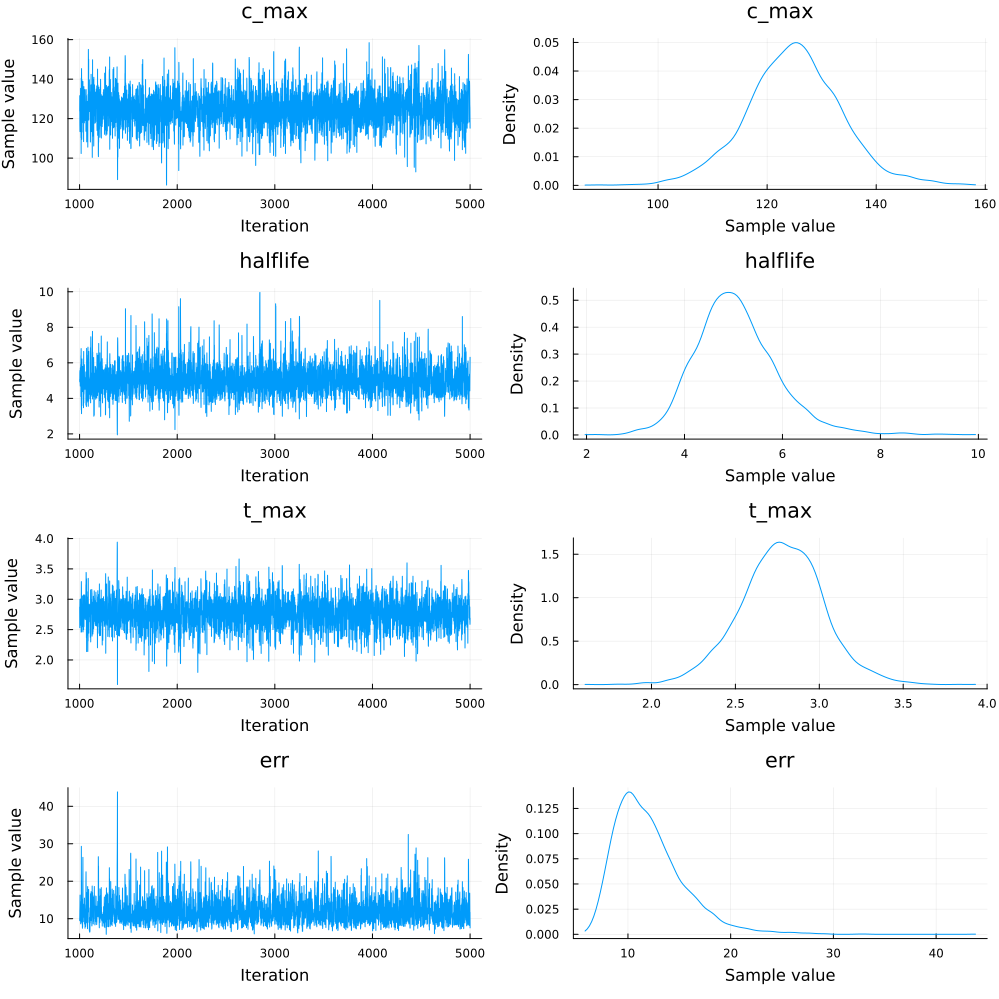

In [211]:
using StatsPlots
plot(chain)

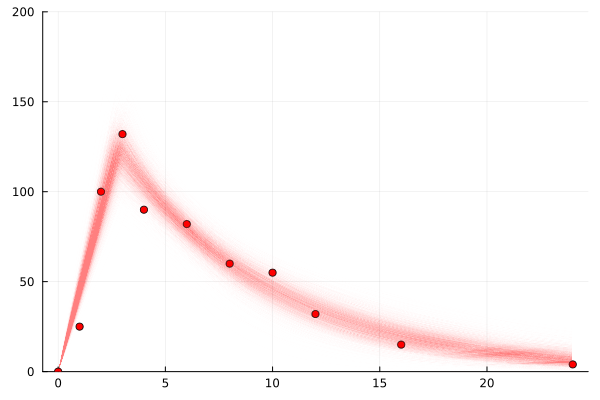

In [212]:
using Tables

gr(fmt=:png)  # make sure not to plot svg or will crash browser
scatter(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=0.5,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

Now that we have shown we can do inference to that find distributions over parameters that fit the curve lets get on to a more realistic task.
Noone gets blood tests every few hours outside of a experiment data gathering exercise.
The most frequent blood tests i have heard of is every 2 weeks, and most are more like every 3-6 months.
So what we are really interested in is inferring what could be happening with blood levels from a single observation.

The practical case is applying in the morning before work, and getting a blood test toward the end of the work day just before the phlebotomist closes up.
So we will look at the sample for `c8`, the blood concentration 8 hours after dosing.
And we want to see a distribution over all possible functions that would lead to that observation.


┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
Sampling:   2%|▉                                        |  ETA: 0:00:40┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
Sampling:   5%|██                                       |  ETA: 0:00:24┌ Warning: The current proposal will be rejected d

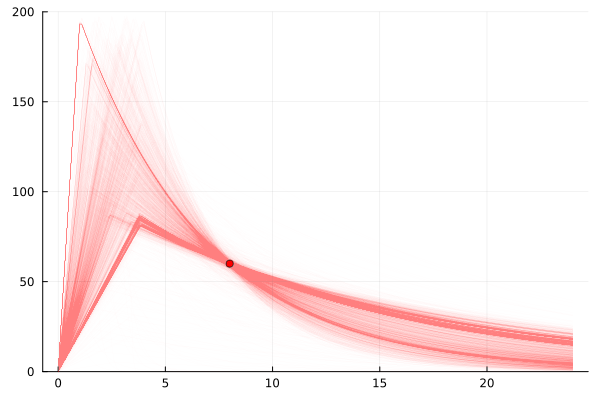

In [217]:
model = single_dose_model() | (;c8=60)
chain=sample(model, NUTS(), 4_000)

scatter(
    [8], [60],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

So that's actually really informative.
There are a range of possible explinations.
From a very small `t_max` and a large `C_max` meaning it peaked eary and has tailed off a lot,
to the more likely ones which look more like the kind of curves we were seeing based on the experimental data with more frequent measurements.
This is really cool.